# Extract and examine RH metrics from a granule: GEDI-style and ATL03-style 

In [ ]:
!pip install -U -r /projects/icesat2_boreal/dps/requirements_main.txt
import geopandas as gpd
import os
import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils
import FilterUtils

import pandas as pd

!pip install plotnine
import plotnine
from plotnine import *

### Extract a CSV with GEDI-style and ATL03-style rh metrics

In [339]:
## NOTE: this ATL08 needs to be v005 not v004

# A few granules from Eric
fpath_dps = '2022/09/22/16/00/34/274695/ATL08_30m_20181015110941_02570106_005_01.h5' # first attempt; granule crossing NA boreal
fpath_dps = '2022/09/28/15/20/58/309979/ATL08_30m_20181015135347_02590102_005_01.h5' # second attempt: granule crossing europe
fpath_dps = '2022/09/28/15/15/37/403913/ATL08_30m_20181015110941_02570106_005_01.h5' # second attempt: granule crossing NA boreal

h5_fn = f'https://maap-ops-workspace.s3.amazonaws.com/lduncanson/dps_output/run_rebinning_ubuntu/master/{fpath_dps}'

h5_fn = h5_fn.replace('https://maap-ops-workspace.s3.amazonaws.com/lduncanson', '/projects/my-private-bucket')
!python /projects/icesat2_boreal/lib/extract_filter_atl08.py -o "/projects/test_data/test_extract_filter_atl08_30m/rhGEDI" -i $h5_fn --no-filter-qual --do_30m --get_gedi_rh
!python /projects/icesat2_boreal/lib/extract_filter_atl08.py -o "/projects/test_data/test_extract_filter_atl08_30m/rhATL03" -i $h5_fn --no-filter-qual --do_30m 


Written by:
	Nathan Thomas	| @Nmt28
	Paul Montesano	| paul.m.montesano@nasa.gov

Min lat: 30.0
Max lat: 80.0
Min lon: -180.0
Max lon: 180.0
Month range: 6-9

ATL08 granule name: 	ATL08_30m_20181015110941_02570106_005_01
Input dir: 		/projects/my-private-bucket/dps_output/run_rebinning_ubuntu/master/2022/09/28/15/15/37/403913

Segment length: 30m
Find src nodata value using max of h_can: 	nan

Building pandas dataframe...
Setting pandas df nodata values to np.nan for some basic eval.
# of ATL08 obs: 		342621
# of ATL08 obs (can pho.>=0): 	342560
# of ATL08 obs (toc pho.>=0): 	342560
# of ATL08 obs (h_can>=0): 	342295
# of ATL08 obs (h_can<0): 	265
Setting out pandas df nodata values: 	3.4028234663852886e+38
Quality Filtering: 	[OFF] (do downstream)
Geographic Filtering: 	[ON] xmin = -180.0, xmax = 180.0, ymin = 30.0, ymax = 80.0
Creating CSV: 		/projects/test_data/test_extract_filter_atl08_30m/rhGEDI/ATL08_30m_20181015110941_02570106_005_01_30m.csv

Written by:
	Nathan Thomas	| @Nmt28


### Read in both CSVs to data frames

In [340]:
GRAN_NAME = os.path.basename(h5_fn).replace('.h5','')
df_gedi = pd.read_csv(f'/projects/test_data/test_extract_filter_atl08_30m/rhGEDI/{GRAN_NAME}_30m.csv')
df_atl03 = pd.read_csv(f'/projects/test_data/test_extract_filter_atl08_30m/rhATL03/{GRAN_NAME}_30m.csv')

### Run our project's filtering across each data frame

In [341]:
atl08_cols_list = ['rh25','rh50','rh60','rh70','rh75','rh80','rh90','h_can','h_max_can', 'ter_slp','h_te_best', 'seg_landcov','sol_el','y','m','doy']
list_lc_h_can_thresh = [0, 60, 60, 60, 60, 60, 60, 50, 50, 50, 50, 50, 50, 20, 10, 10, 5, 5, 0, 0, 0, 0, 0]

rh_type_list = ['gedi', 'atl03']

df_atl08_list = []

for i, atl08 in enumerate([df_gedi, df_atl03]):
    
    # Compute a rough estimate of canopy cover
    atl08['can_cover'] = ( atl08['n_ca_ph'] + atl08['n_toc_ph'] ) / (atl08['n_ca_ph'] + atl08['n_toc_ph'] + atl08['n_te_ph'])
    
    # Identify rh metric type
    atl08['rhtype'] = rh_type_list[i]
    
    atl08 = FilterUtils.prep_filter_atl08_qual(atl08)
    atl08_pdf_filt = FilterUtils.filter_atl08_qual_v3(atl08, SUBSET_COLS=True, DO_PREP=False,
                                                          subset_cols_list = atl08_cols_list + ['seg_cover', 'can_cover', 'rhtype'], #, 'granule_name'
                                                   filt_cols=['h_can','h_dif_ref','m','msw_flg','beam_type','seg_snow','sig_topo'], 
                                                   list_lc_h_can_thresh= list_lc_h_can_thresh,
                                                   thresh_sol_el = 25,
                                                   thresh_h_can=100, thresh_h_dif=25, thresh_sig_topo=2.5, month_min=6, month_max=10)
    # Adjust output
    #
    out_cols = ['lon', 'lat', 'can_cover','seg_landcov'] + [col for col in atl08_pdf_filt if col.startswith('rh') or col.startswith('h_')] 
    atl08_pdf_filt = atl08_pdf_filt[out_cols]
    
    # Set names for numeric land cover values
    class_values = [ 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200] 
    class_names = ['No data','Closed forest\nevergreen needle','Closed forest\ndeciduous needle','Closed forest\nevergreen_broad','Closed forest\ndeciduous broad','Closed forest\nmixed', 'Closed forest\nunknown','Open forest\nevergreen needle',
                'Open forest\ndeciduous needle','Open forest\nevergreen_broad','Open forest\ndeciduous_broad','Open forest\nmixed', 'Open forest\nunknown', 'Shrubs','Herbaceous', 'Herbaceous\nwetleand','Moss/lichen', 'Bare/sparse','Cultivated/managed',
                'Urban/built', 'Snow/ice','Permanent\nwater', 'Open sea']
    atl08_pdf_filt['seg_landcov'] = atl08_pdf_filt['seg_landcov'].map(dict(zip(class_values, class_names)))
    
    atl08_gdf = gpd.GeoDataFrame(atl08_pdf_filt, geometry=gpd.points_from_xy(atl08_pdf_filt.lon, atl08_pdf_filt.lat), crs='epsg:4326')
    
    df_atl08_list.append(atl08_gdf) 


Pre-filter data cleaning...
Pandas version: 1.2.2
	Get beam type from orbit orientation and ground track: ['Strong' 'Weak']
	Cast some columns to:
		type float: ['lat', 'lon', 'h_can', 'h_te_best', 'ter_slp']
		type integer: ['n_ca_ph', 'n_seg_ph', 'n_toc_ph', 'msw_flg', 'seg_snow']

Filtering by quality
	Before quality filtering: 		331876 observations in the input dataframe.
	After msw_flg=0: 		228967 observations in the dataframe.
	After beam_type=Strong: 		115743 observations in the dataframe.
	After seg_snow=1: 		107405 observations in the dataframe.
	Land cover threshold dictionary: 
{0: 0, 111: 60, 113: 60, 112: 60, 114: 60, 115: 60, 116: 60, 121: 50, 123: 50, 122: 50, 124: 50, 125: 50, 126: 50, 20: 20, 30: 10, 90: 10, 100: 5, 60: 5, 40: 0, 50: 0, 70: 0, 80: 0, 200: 0}
	After land-cover specific h_can thresholds: 		100592 observations in the dataframe.
	After h_can_unc <5, seg_cover<32767, sol_el<25, sig_topo<2.5, h_dif_ref<25: 		21851 observations in the dataframe.
	After month

### Concatenate to basically double the df row-wise

In [342]:
df_concat = pd.concat(df_atl08_list)
df_concat.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 43232 entries, 817 to 278650
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   lon          43232 non-null  float64 
 1   lat          43232 non-null  float64 
 2   can_cover    43232 non-null  float64 
 3   seg_landcov  43232 non-null  object  
 4   rh25         43232 non-null  float64 
 5   rh50         43232 non-null  float64 
 6   rh60         43232 non-null  float64 
 7   rh70         43232 non-null  float64 
 8   rh75         43232 non-null  float64 
 9   rh80         43232 non-null  float64 
 10  rh90         43232 non-null  float64 
 11  h_can        43232 non-null  float64 
 12  h_max_can    43232 non-null  float64 
 13  h_te_best    43232 non-null  float64 
 14  rhtype       43232 non-null  object  
 15  geometry     43232 non-null  geometry
dtypes: float64(13), geometry(1), object(2)
memory usage: 5.6+ MB


### Map a subset of the ATL08 obs from both GEDI and ATL03 sets

In [361]:
# Note: this is set to False in order to commit a small notebook file to GitHub
if False:
    maplib.MAP_ATL08_FOLIUM(df_concat.cx[:,50:70], MAP_COL='h_can', GROUP_COL='rhtype', DO_NIGHT=False, LAYER_FN = None, RADIUS=3)

### Join on lat,lon to get columns they way you want for scatter-plotting

In [344]:
df_merge = pd.merge(df_atl08_list[0], df_atl08_list[1], how='inner', on = ['lon','lat'], suffixes = ["_" + type for type in rh_type_list])

bins = [0, 10, 20, 30, 40, 50, 100]
labels = bins[1:]
df_merge['can_cover_atl03_binned'] = pd.cut(df_merge['can_cover_atl03'] * 100, bins=bins, labels=labels)

# Differences
df_merge['h_can_dif_atl03_gedi'] = df_merge['h_can_atl03'] - df_merge['h_can_gedi']

## Sensitivity of rh metrics to algorithm type
#### Show scatterplots of GEDI vs ATL03 calcs for h_can, rh50, & rh25
The lower rh metrics are more significantly affected by the difference in algorithm
Biomass algorithms use higher rh metrics because of this sensitivity of lower rh metrics to algorithm type

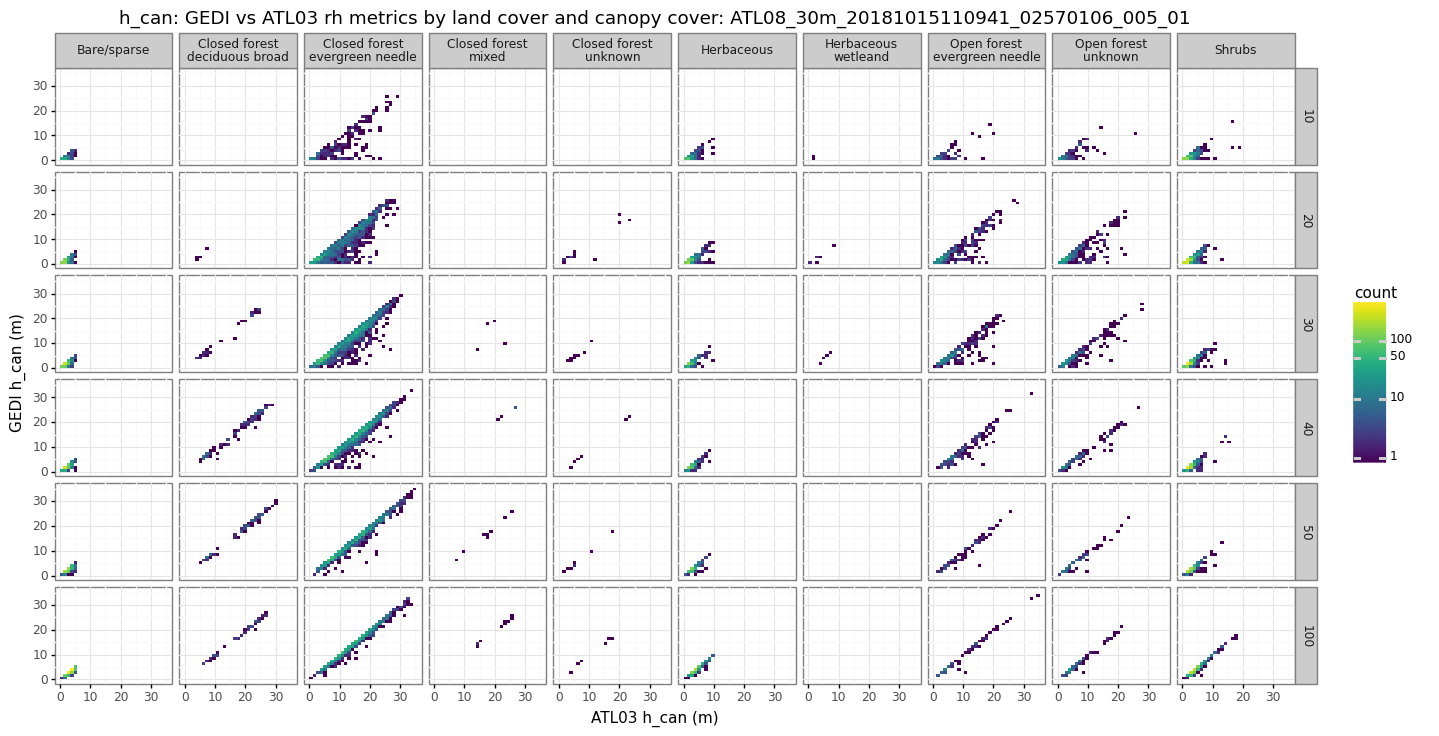

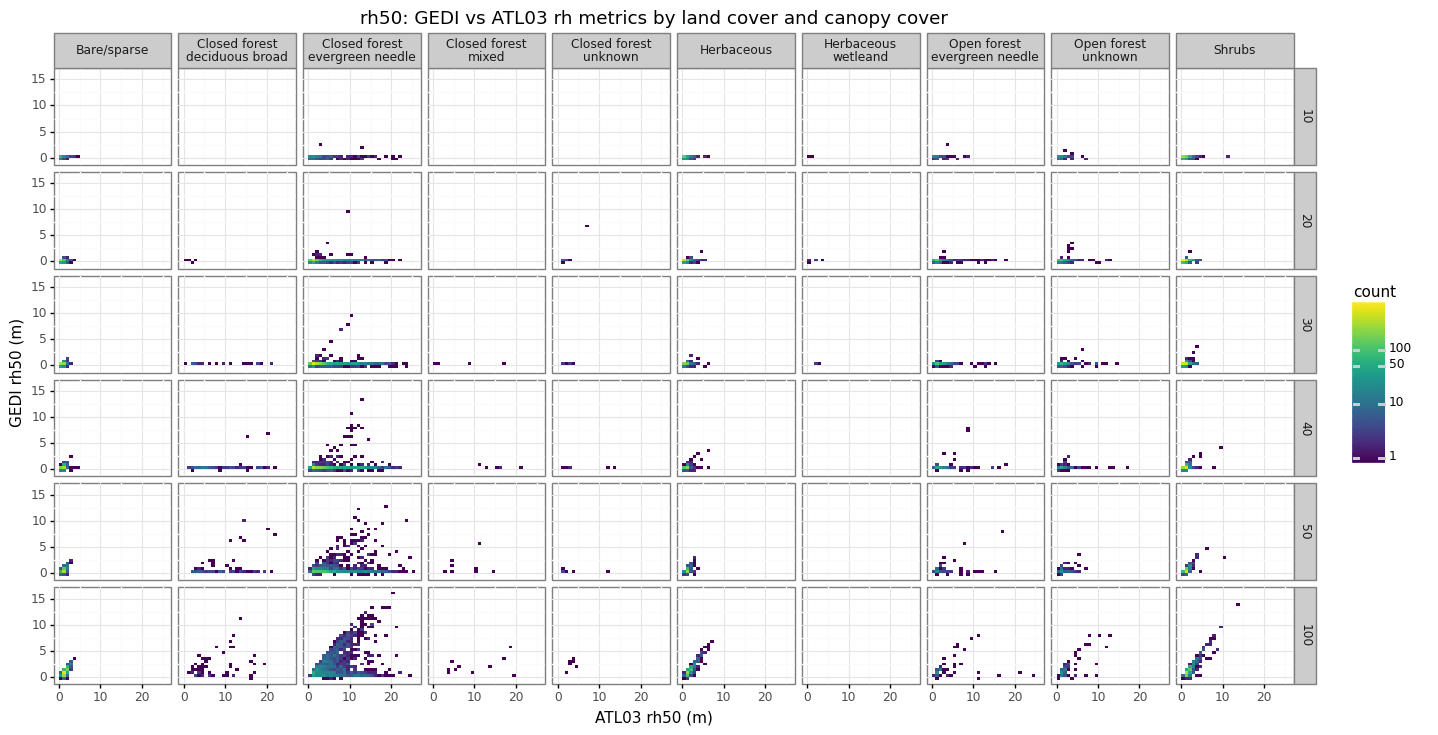

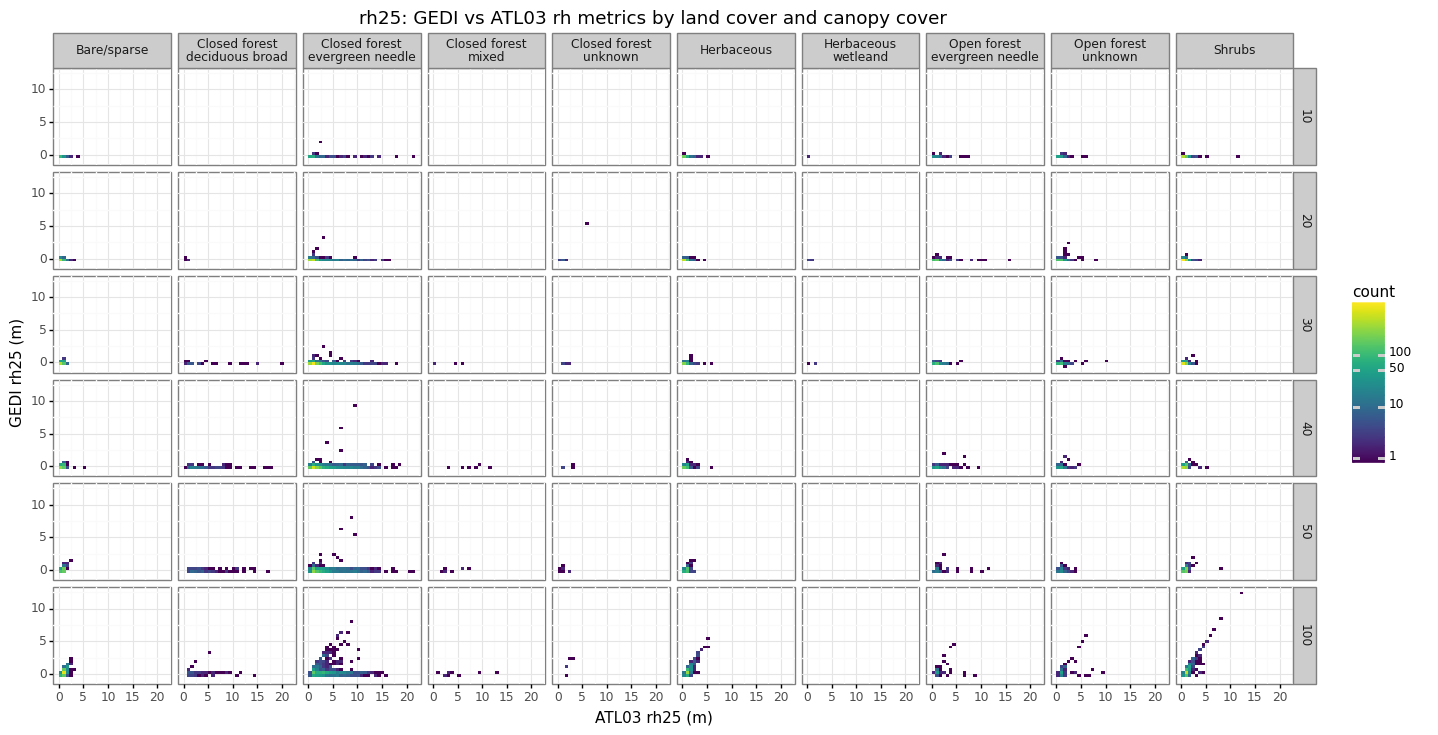

In [362]:
plotnine.options.figure_size = (16, 8)

print(
    ggplot(df_merge, aes(x='h_can_atl03', y='h_can_gedi')) + geom_bin2d() + theme_bw() + facet_grid('can_cover_atl03_binned~seg_landcov_gedi') +
    scale_fill_cmap(cmap_name='viridis', trans='log', breaks=[1,10,50,100,1000]) +
    labs(title=f'h_can: GEDI vs ATL03 rh metrics by land cover and canopy cover: {GRAN_NAME}', y='GEDI h_can (m)', x = 'ATL03 h_can (m)') 
) 
print(
    ggplot(df_merge, aes(x='rh50_atl03', y='rh50_gedi')) + geom_bin2d() + theme_bw() + facet_grid('can_cover_atl03_binned~seg_landcov_gedi') +
    scale_fill_cmap(cmap_name='viridis', trans='log', breaks=[1,10,50,100,1000]) +
    labs(title='rh50: GEDI vs ATL03 rh metrics by land cover and canopy cover', y='GEDI rh50 (m)', x = 'ATL03 rh50 (m)') 
) 
print(
    ggplot(df_merge, aes(x='rh25_atl03', y='rh25_gedi')) + geom_bin2d() + theme_bw() + facet_grid('can_cover_atl03_binned~seg_landcov_gedi') +
    scale_fill_cmap(cmap_name='viridis', trans='log', breaks=[1,10,50,100,1000]) +
    labs(title='rh25: GEDI vs ATL03 rh metrics by land cover and canopy cover', y='GEDI rh25 (m)', x = 'ATL03 rh25 (m)') 
) 
# print(
#     ggplot(df_merge, aes(x='h_can_dif_atl03_gedi')) + geom_histogram() + theme_bw() + facet_grid('can_cover_atl03_binned~seg_landcov_gedi') + coord_cartesian(xlim=[0,5]) +
#     labs(title=f'Difference in h_can: ATL03-GEDI rh metrics by land cover and canopy cover: {GRAN_NAME}', x = 'Difference ATL03 - GEDI h_can (m)') 
# ) 

## Group summaries show where on landscape do the largest differences in rh metric appear
### Statistical summary of differences by group

In [346]:
stats_list = ['count', 'std', 'mean', 'median','max']

In [347]:
print(GRAN_NAME)
df_merge.groupby(['can_cover_atl03_binned']).agg({'h_can_dif_atl03_gedi': stats_list})

ATL08_30m_20181015110941_02570106_005_01


h_can_dif_atl03_gedi                                \
                                      count       std      mean    median   
can_cover_atl03_binned                                                      
10                                     1378  2.337793  1.550529  0.777310   
20                                     4211  2.114695  1.446204  0.696255   
30                                     4413  1.667006  1.157130  0.608418   
40                                     4007  1.225922  0.863883  0.499779   
50                                     3156  0.848896  0.633635  0.401625   
100                                    4216  0.471496  0.346885  0.209343   

                                   
                              max  
can_cover_atl03_binned             
10                      23.597344  
20                      19.557119  
30                      19.883292  
40                      14.643125  
50                      13.379519  
100                      7.028818

In [348]:
df_merge.groupby(['seg_landcov_gedi']).agg({'h_can_dif_atl03_gedi': stats_list})

h_can_dif_atl03_gedi                      \
                                               count       std      mean   
seg_landcov_gedi                                                           
Bare/sparse                                     3616  0.468074  0.423939   
Closed forest\ndeciduous broad                   300  0.830956  0.801725   
Closed forest\nevergreen needle                 7413  2.028438  1.430207   
Closed forest\nmixed                              28  2.693122  1.227424   
Closed forest\nunknown                            42  1.797606  1.161960   
Herbaceous                                      2647  0.738693  0.597920   
Herbaceous\nwetleand                              13  0.559937  0.813874   
Open forest\nevergreen needle                    989  2.396987  1.724777   
Open forest\nunknown                            1016  2.169815  1.364877   
Shrubs                                          5317  0.775245  0.585337   

                                                      
                                   median        max  
seg_landcov_gedi                                      
Bare/sparse                      0.279603   4.530018  
Closed forest\ndeciduous broad   0.548759   5.959753  
Closed forest\nevergreen needle  0.752842  23.597344  
Closed forest\nmixed             0.514229  13.251774  
Closed forest\nunknown           0.649700  10.389609  
Herbaceous                       0.370224   8.301614  
Herbaceous\nwetleand             0.863909   1.762118  
Open forest\nevergreen needle    0.809357  18.149719  
Open forest\nunknown             0.604818  18.210916  
Shrubs                           0.371558  13.705295

In [349]:
smry_dif_h_can_cancov_landcov = df_merge.groupby(['can_cover_atl03_binned','seg_landcov_gedi']).agg({'h_can_dif_atl03_gedi': stats_list})
smry_dif_h_can_cancov_landcov = pd.DataFrame(smry_dif_h_can_cancov_landcov).reset_index()

smry_dif_h_can_cancov_landcov.columns = ['_'.join(col) for col in smry_dif_h_can_cancov_landcov.columns.values]
smry_dif_h_can_cancov_landcov[smry_dif_h_can_cancov_landcov.seg_landcov_gedi_ == 'Closed forest\nmixed'].head()

,can_cover_atl03_binned_,seg_landcov_gedi_,h_can_dif_atl03_gedi_count,h_can_dif_atl03_gedi_std,h_can_dif_atl03_gedi_mean,h_can_dif_atl03_gedi_median,h_can_dif_atl03_gedi_max
3,10,Closed forest\nmixed,0,NaN,NaN,NaN,NaN
13,20,Closed forest\nmixed,0,NaN,NaN,NaN,NaN
23,30,Closed forest\nmixed,4,5.978934,5.463233,3.933203,13.251774
33,40,Closed forest\nmixed,6,0.380242,0.699529,0.570948,1.228633
43,50,Closed forest\nmixed,8,0.652083,0.640774,0.520148,2.068964


### Plot heatmaps of some of the stats for groups

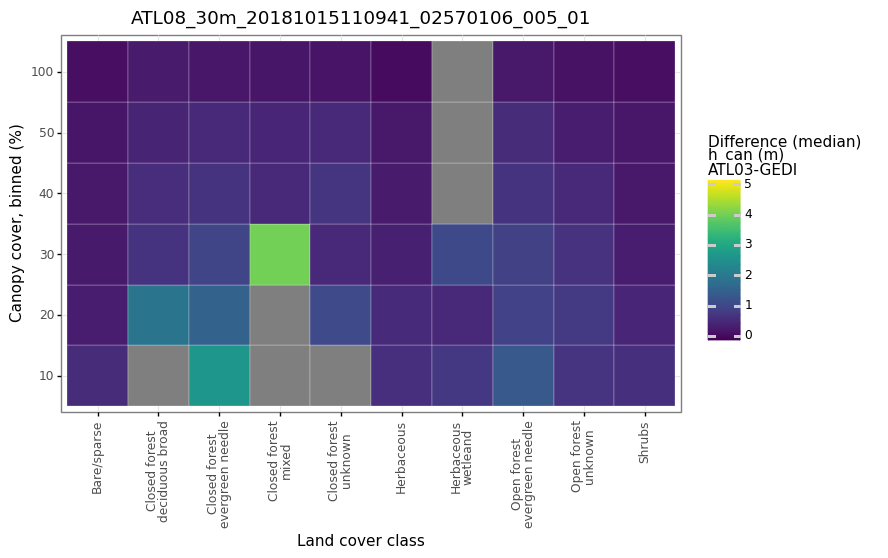

<ggplot: (8757028182985)>

In [350]:
plotnine.options.figure_size = (8, 8)
(
    ggplot(smry_dif_h_can_cancov_landcov, aes(x = 'seg_landcov_gedi_', y = 'can_cover_atl03_binned_', fill = 'h_can_dif_atl03_gedi_median')) +
    geom_tile(color = "white") + 
    scale_fill_cmap(cmap_name='viridis', name='Difference (median)\nh_can (m)\nATL03-GEDI\n\n', limits=[0,5]) +
    coord_fixed() +
    theme_bw() +
    theme(axis_text_x=element_text(rotation=90))+
    labs(y='Canopy cover, binned (%)',x='Land cover class', title=GRAN_NAME)
)



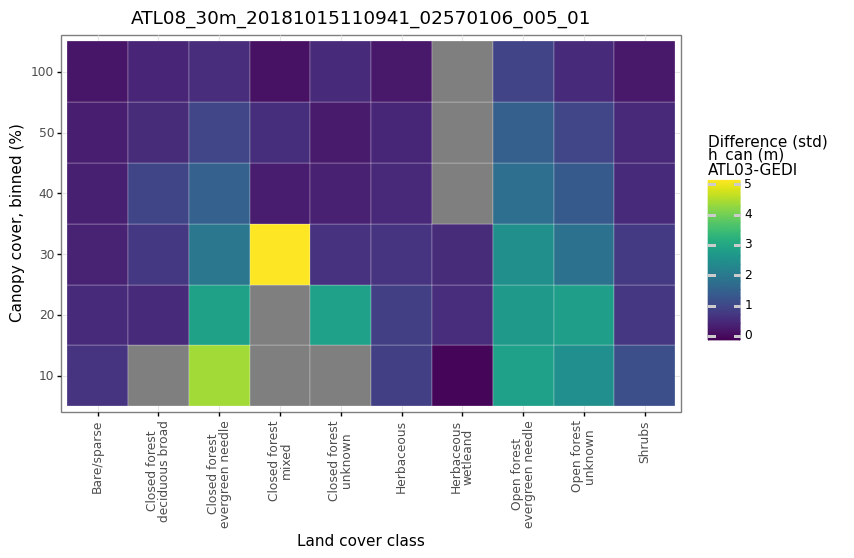

<ggplot: (8757031365877)>

In [351]:
(
    ggplot(smry_dif_h_can_cancov_landcov, aes(x = 'seg_landcov_gedi_', y = 'can_cover_atl03_binned_', fill = 'h_can_dif_atl03_gedi_std')) +
    geom_tile(color = "white") + 
    scale_fill_cmap(cmap_name='viridis', name='Difference (std)\nh_can (m)\nATL03-GEDI\n\n', limits=[0,5]) +
    coord_fixed() +
    theme_bw() +
    theme(axis_text_x=element_text(rotation=90))+
    labs(y='Canopy cover, binned (%)',x='Land cover class', title=GRAN_NAME)
)

## Use heatmaps to identify portions of landscape where rh metric difs are largest
### Look at heatmaps, maps obs for the groups that have largest difs
doesnt seem like the big diffs are geographically clustered

#### Here we look at difs between the two rh calcs for sparse cover (can cov bin = 10)
In low cover, the largest difs in these two rh calcs seem to be near land cover **edges**  
Zoom into the highest value points (largest diffs between the 2 calcs)

In [360]:
# Note: this is set to False in order to commit a small notebook file to GitHub
if False:
    maplib.MAP_ATL08_FOLIUM(df_merge.dropna()[df_merge['can_cover_atl03_binned'] == 10], MAP_COL='h_can_dif_atl03_gedi', GROUP_COL='seg_landcov_gedi', DO_NIGHT=False, LAYER_FN = None, RADIUS=3)

### Misc plotting

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 58'. Pick better value with 'binwidth'.


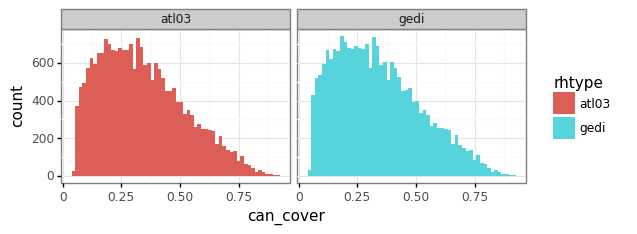

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 90'. Pick better value with 'binwidth'.


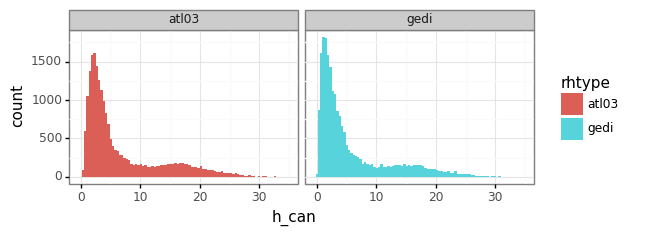

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 90'. Pick better value with 'binwidth'.


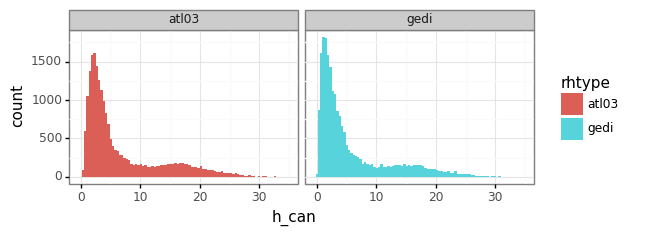

In [353]:
plotnine.options.figure_size = (6, 2)
print(
    ggplot(df_concat, aes(x='can_cover', fill='rhtype')) + geom_histogram() + facet_wrap('~rhtype') + theme_bw()
)  
print(
    ggplot(df_concat, aes(x='h_can', fill='rhtype')) + geom_histogram() + facet_wrap('~rhtype')+ theme_bw()
)   
print(
    ggplot(df_concat, aes(x='h_can', fill='rhtype')) + geom_histogram() + facet_wrap('~rhtype')+ theme_bw()
) 